# **Curso IA desde Cero**

* Dr. Irvin Hussein López Nava
* M.C. Joan M. Raygoza Romero

## Librerias

In [15]:
!pip install gensim
from gensim.models import FastText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.5 MB/s eta 0:00:00


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

## Leer el conjunto de datos

In [2]:
csv_path = "book_data.csv"
df = pd.read_csv(csv_path)
df.head()

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


## Preparar datos de entrada y sus etiquetas

In [3]:
texts = df['summary'].astype(str).values
labels = df['genre'].astype(str).values

print(texts[0])
print(labels[0])

 Drowned Wednesday is the first Trustee among the Morrow Days who is on Arthur's side and wishes the Will to be fulfilled. She appears as a leviathan/whale and suffers from Gluttony. The book begins when Leaf is visiting Arthur and they are discussing the invitation that Drowned Wednesday sent him. Arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter Tuesday's Treasure Tower. Suddenly, the hospital room becomes flooded with water as the two are transported to the Border Sea of the House. Leaf is snatched away by a large ship with green sails, known as the Flying Mantis, while Arthur remains in his bed. When the Medallion given him by the immortal called the Mariner apparently fails to summon help, Arthur is without hope. Eventually, a buoy marking the pirate Elishar Feverfew's treasure floats toward him. As soon as Arthur opens it, his hand is marked with a bloody red colour. Arthur now has the Red Hand, by which Feverfew marks whoever h

## Codificar etiquetas (géneros) como enteros

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print(y[:5])

[1 1 1 1 1]


## Separar en train / test

In [5]:
x_train, x_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42, stratify=y)

## Vectorización de texto

In [6]:
max_tokens = 20000   # tamaño del vocabulario
max_len = 200        # longitud máxima (en palabras) tras el padding

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_len
)

# Adaptar el vocabulario a los textos de entrenamiento
text_vectorizer.adapt(x_train)
print(text_vectorizer(x_train[0]))

tf.Tensor(
[   16  1727  4060   831     5    45  2419    99  4564    34     6   482
  1968   159 13416     3   708    29  4705     2  3566  1994  1933    14
    33     5     2   164     1     5   318   307  8959  8050  5045   174
  6888   758   168   409  1303     2  3852  8303     4    13   206  3931
    40    73   845    11    29  1367     8     2  1507  5304     5 13416
   414     2 19926  1094   430  2844   325  3751   181   462  6479 11471
 16535     1  3845  2170 15939     1     4  2978  5262    83    32     2
  1752   125   839  3931     8     6  2018   220  2377     4  8176    16
     9    86   348   382   274     5   390    27  4934     4  8303     4
    13   206   364     2  1056  1601     5    29   217     3   298    29
    97 13416     4  1464   119     2    65  8303     4  3931   129    61
     2  2340     3   128    70    20   716   104   101     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

## Crear datasets para TensorFlow

In [7]:
batch_size = 32

def make_dataset(texts, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(texts))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train, training=True)
test_ds  = make_dataset(x_test,  y_test,  training=False)

# Aplicar la vectorización dentro del pipeline
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
test_ds  = test_ds.map(lambda x, y: (text_vectorizer(x), y))

## Definir la red neuronal con embeddings

In [8]:
embedding_dim = 64

model = tf.keras.Sequential([
    layers.Embedding(
        input_dim=max_tokens,
        output_dim=embedding_dim,
        input_length=max_len
    ),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 7. Entrenar el modelo

In [9]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.1935 - loss: 2.1596 - val_accuracy: 0.2725 - val_loss: 1.9963
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2554 - loss: 1.9727 - val_accuracy: 0.3369 - val_loss: 1.9474
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3625 - loss: 1.8774 - val_accuracy: 0.3734 - val_loss: 1.8249
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4377 - loss: 1.7127 - val_accuracy: 0.4303 - val_loss: 1.6500
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5540 - loss: 1.4071 - val_accuracy: 0.4850 - val_loss: 1.4609
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6557 - loss: 1.1224 - val_accuracy: 0.5622 - val_loss: 1.2932
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7465 - loss: 0.8509 - val_accuracy: 0.5815 - val_loss: 1.2138
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8161 - loss: 0.6691 - val_accu

## Graficar función de pérdida y accuracy

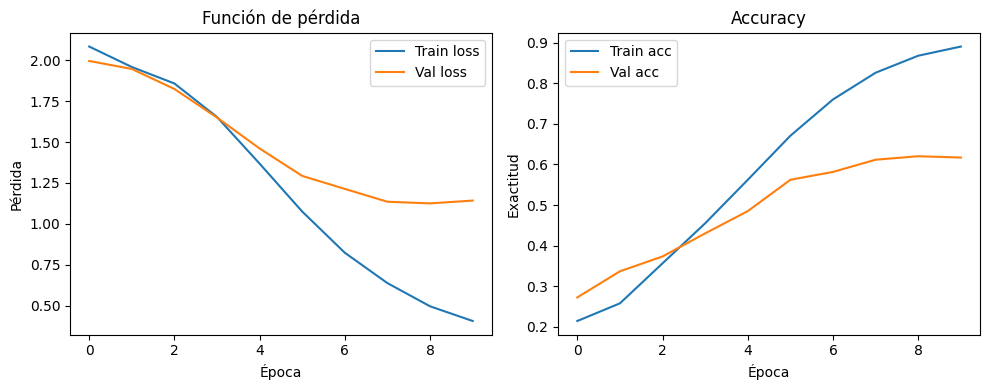

In [10]:
plt.figure(figsize=(10, 4))

# PÉRDIDA
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Función de pérdida")
plt.legend()

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Evaluar el modelo

In [11]:
loss, acc = model.evaluate(test_ds)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6273 - loss: 1.1369
Test loss: 1.1424
Test accuracy: 0.6170


## Matriz de confusión en el conjunto de prueba

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<Figure size 800x800 with 0 Axes>

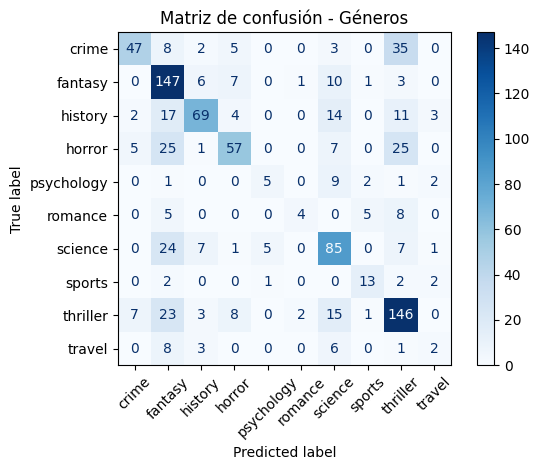

In [12]:
X_test_vec = text_vectorizer(tf.constant(x_test))
pred_probs = model.predict(X_test_vec, batch_size=batch_size)
y_pred = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Matriz de confusión - Géneros")
plt.tight_layout()
plt.show()

## Ejemplo de predicción en nuevos resúmenes


In [13]:
ejemplos = [
    "A young wizard discovers his magical heritage and attends a school of witchcraft.",
    "A detective investigates a series of mysterious murders in a small town."
]

ejemplos_tensor = tf.constant(ejemplos)
ejemplos_vec = text_vectorizer(ejemplos_tensor)
pred_probs = model.predict(ejemplos_vec)
pred_labels = np.argmax(pred_probs, axis=1)
pred_genres = label_encoder.inverse_transform(pred_labels)

for texto, genero in zip(ejemplos, pred_genres):
    print("Resumen:", texto)
    print("Género predicho:", genero)
    print("-" * 40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Resumen: A young wizard discovers his magical heritage and attends a school of witchcraft.
Género predicho: fantasy
----------------------------------------
Resumen: A detective investigates a series of mysterious murders in a small town.
Género predicho: thriller
----------------------------------------


# Texto con FastText

## Tokenización simple

In [19]:
def simple_tokenize(text):
    # Muy básico: minúsculas + split por espacios
    return text.lower().strip().split()

tokenized_texts = [simple_tokenize(t) for t in texts]


## Extraer embeddings con FastText

In [20]:
embedding_dim = 100  # tamaño del vector de embedding

ft_model = FastText(
    sentences=tokenized_texts,
    vector_size=embedding_dim,
    window=8,
    min_count=10,      # incluir palabras raras; pon >1 si tienes mucho texto
    workers=4,
    sg=1              # 1 = skip-gram, 0 = CBOW
)

### Función para obtener embedding de cada documento (promedio de vectores de sus palabras)

In [21]:
def document_vector(tokens, model, embedding_dim):
    vecs = []
    for tok in tokens:
        if tok in model.wv:
            vecs.append(model.wv[tok])
    if len(vecs) == 0:
        # Si el resumen está vacío o no hay palabras conocidas:
        return np.zeros(embedding_dim)
    return np.mean(vecs, axis=0)

# Crear la matriz de características X con embeddings de cada summary
X = np.array([
    document_vector(tokens, ft_model, embedding_dim)
    for tokens in tokenized_texts
])

## Train / Test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Definir red neuronal en TensorFlow

In [25]:
model = models.Sequential([
    layers.Input(shape=(embedding_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,114 (27.79 KB)

 Trainable params: 7,114 (27.79 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenar el modelo

In [30]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4861 - loss: 1.4301 - val_accuracy: 0.5172 - val_loss: 1.3617
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5107 - loss: 1.3801 - val_accuracy: 0.5107 - val_loss: 1.3618
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5216 - loss: 1.3550 - val_accuracy: 0.5150 - val_loss: 1.3373
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5083 - loss: 1.3575 - val_accuracy: 0.5354 - val_loss: 1.3222
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5258 - loss: 1.3361 - val_accuracy: 0.5376 - val_loss: 1.3138
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5155 - loss: 1.3420 - val_accuracy: 0.5386 - val_loss: 1.3042
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5349 - loss: 1.3228 - val_accuracy: 0.5547 - val_loss: 1.2884
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5246 - loss: 1.3289 - val_accuracy:

## Evaluación

In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# También con sklearn por si quieres
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Accuracy (sklearn):", accuracy_score(y_test, y_pred))

Test loss: 1.2239
Test accuracy: 0.5826
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy (sklearn): 0.5826180257510729


## Ejemplo de predicción

In [32]:
def predict_genre(summary_text):
    tokens = simple_tokenize(summary_text)
    doc_vec = document_vector(tokens, ft_model, embedding_dim)
    doc_vec = np.expand_dims(doc_vec, axis=0)  # shape (1, embedding_dim)

    probs = model.predict(doc_vec)[0]
    pred_label = np.argmax(probs)
    genre = label_encoder.inverse_transform([pred_label])[0]
    return genre, probs

ejemplo = "A young wizard discovers his magical heritage and attends a school of witchcraft."
genre_pred, probs = predict_genre(ejemplo)
print("Resumen:", ejemplo)
print("Género predicho:", genre_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Resumen: A young wizard discovers his magical heritage and attends a school of witchcraft.
Género predicho: fantasy
